In [ ]:
from google.colab import drive

drive.mount("/content/drive")
%cd '/content/drive/MyDrive/task4_materialType/'

Mounted at /content/drive
/content/drive/MyDrive/task4_materialType


In [ ]:
import numpy as np
import csv
import torch
from IPython.display import Image
import matplotlib.pyplot as plt

import yaml
import argparse
import time
import copy

import numpy as np
import torch # root package
import torchvision
# from data import Cifar, IMBALANCECIFAR10

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  #dataset representation and loader
import torchvision.transforms as transforms #composable transform

# for transfer learning
from torchvision import models
from torch.optim import lr_scheduler

from sklearn.metrics import f1_score

In [ ]:
torch.__version__

'1.13.0+cu116'

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
task = 8
batch_size=8 #16 #128

In [ ]:
if task == 4:
        #label: 1: steel, 0: other
        org_X_train_data_dir = 'data/task4_X_train_aug.npy'
        org_Y_train_data_dir = 'data/task4_y_train_aug.npy'
        org_X_test_data_dir = 'data/task4_X_test.npy'
        org_Y_test_data_dir = 'data/task4_y_test.npy'
        num_classes = 2
        claases = ['other', 'steel']
elif task == 8:
        # label: 0: combined damage, 1: Flexural damage, 2: Undamaged state, 3: Shear damage 
        org_X_train_data_dir = 'data/task8_X_train_aug.npy'
        org_Y_train_data_dir = 'data/task8_y_train_aug.npy'
        org_X_test_data_dir = 'data/task8_X_test.npy'
        org_Y_test_data_dir = 'data/task8_y_test.npy'
        num_classes = 4
        claases = ['comb', 'flex', 'ud', 'shear']

x_train_dataset = torch.from_numpy(np.load(org_X_train_data_dir)) 
y_train_dataset = torch.from_numpy(np.load(org_Y_train_data_dir)) 
x_test_dataset = torch.from_numpy(np.load(org_X_test_data_dir))
y_test_dataset = torch.from_numpy(np.load(org_Y_test_data_dir))


In [ ]:
# x_train_dataset_np = np.load(org_X_train_data_dir)

In [ ]:
# # image normalization
# (N, W, H, rgb) = x_train_dataset_np.shape
# r_sum = 0
# g_sum = 0
# b_sum = 0
# total = N*W*H
# r_sum_sq = 0
# g_sum_sq = 0
# b_sum_sq = 0
# for n in range(N):
#   d = x_train_dataset_np[n]
#   r_sum += np.sum(d[:, :, 0])
#   g_sum += np.sum(d[:, :, 1])
#   b_sum += np.sum(d[:, :, 2])
#   d = x_train_dataset_np[n]**2
#   r_sum_sq += np.sum(d[:, :, 0])
#   g_sum_sq += np.sum(d[:, :, 1])
#   b_sum_sq += np.sum(d[:, :, 2])

# r_avg = r_sum/total
# g_avg = g_sum/total
# b_avg = b_sum/total

# r_var = (r_sum_sq/total-r_avg**2)
# g_var = (g_sum_sq/total-g_avg**2)
# b_var = (b_sum_sq/total-b_avg**2)
# print("Mean:", r_avg, g_avg, b_avg, "\n STD:", r_var, g_var, b_var)

Mean: 14.089319695833522 7.1091513157335475 5.9904674034887275 
 STD: 3529.3760838531225 3388.2175615361643 3409.0819198191507


In [ ]:
# shapes should be (N, 3, W, H)
x_train_dataset = x_train_dataset.permute(0,3,1,2)
x_test_dataset = x_test_dataset.permute(0,3,1,2)

In [ ]:
# size = 8312
# some data statistics

# element-wise:
# torch.eq(y_train_dataset, torch.tensor([0,1])).sum() #3612
# torch.eq(y_train_dataset, torch.tensor([1,0])).sum() #13012
total_no = y_train_dataset.shape[0]
class0 = torch.tensor([1,0,0,0])
class1 = torch.tensor([0,1,0,0])
class2 = torch.tensor([0,0,1,0])
class3 = torch.tensor([0,0,0,1])
class0_no = y_train_dataset.eq(class0)[:,0].sum() # 1193
class1_no = y_train_dataset.eq(class1)[:,1].sum() # 476
class2_no = y_train_dataset.eq(class2)[:,2].sum() # 1598
class3_no = y_train_dataset.eq(class3)[:,3].sum() # 826

print("Class 0 is", class0_no*100/total_no, "% of the train data.")
print("Class 1 is", class1_no*100/total_no, "% of the train data.")
print("Class 2 is", class2_no*100/total_no, "% of the train data.")
print("Class 3 is", class3_no*100/total_no, "% of the train data.")

total_no = y_test_dataset.shape[0]
class0_no = y_test_dataset.eq(class0)[:,0].sum(dim=0) # 132
class1_no = y_test_dataset.eq(class1)[:,1].sum(dim=0) # 46
class2_no = y_test_dataset.eq(class2)[:,2].sum(dim=0) # 215
class3_no = y_test_dataset.eq(class3)[:,3].sum(dim=0) # 99

print("Class 0 is", class0_no*100/total_no, "% of the test data.")
print("Class 1 is", class1_no*100/total_no, "% of the test data.")
print("Class 2 is", class2_no*100/total_no, "% of the test data.")
print("Class 3 is", class3_no*100/total_no, "% of the test data.")

Class 0 is tensor(29.1473) % of the train data.
Class 1 is tensor(11.6296) % of the train data.
Class 2 is tensor(39.0423) % of the train data.
Class 3 is tensor(20.1808) % of the train data.
Class 0 is tensor(26.8293) % of the test data.
Class 1 is tensor(9.3496) % of the test data.
Class 2 is tensor(43.6992) % of the test data.
Class 3 is tensor(20.1220) % of the test data.


In [ ]:
# Normalizing images
mu1 = 14.089
mu2 = 7.109
mu3 = 5.99
std1 = 3529.376**(1/2)
std2 = 3388.218**(1/2)
std3 = 3409.082**(1/2)
transform = transforms.Compose(
    [transforms.Normalize((mu1, mu2, mu3), (std1, std2, std3))])

x_train_dataset = transform(x_train_dataset)
x_test_dataset = transform(x_test_dataset)

del mu1, mu2, mu3, std1, std2, std3

In [ ]:
# need to add X & y 
class MyDataSet(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(MyDataSet, self).__init__()
    # store the raw tensors
    self._x = x
    self._y = y

  def __len__(self):
    # a DataSet must know it size
    return self._x.shape[0]

  def __getitem__(self, index):
    x = self._x[index, :]
    y = self._y[index, :]
    return x, y
train_dataset = MyDataSet(x_train_dataset, y_train_dataset)
test_dataset = MyDataSet(x_test_dataset, y_test_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=2)

In [ ]:
learning_rate = 1e-4
reg= 0.001 
epochs= 10
warmup = 0.001
momentum= 0.9
model_name = 'MyModel'
loss_type= 'CE' #'CE' #'focal'
save_best = True # False

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(MyModel, self).__init__()
        # 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2) #55*55*64
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=2, padding=2) #28*28*192
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1) #28*28*384
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1) #28*28*256
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1) #28*28*256
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()
        # self.batchnorm1 = nn.BatchNorm2d(32)# affine=False (without learnabe parameter)
        # self.batchnorm2 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.3)
        # BN and droput not needed together!


    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.drop1(x)
        x = self.relu(self.conv5(x))
        x = self.maxpool(x)
        x = self.avgpool(x) #x shape=(batch, 256, 6,6)

        x_flat = torch.flatten(x, start_dim = 1) #x_flat shape= (256, 9216)
        x_flat = self.relu(self.fc1(x_flat)) 
        x_flat = self.drop2(x_flat)
        x_flat = self.relu(self.fc2(x_flat))
        x_flat = self.fc3(x_flat)

        return self.sigmoid(x_flat) #self.softmax(x_flat)

In [ ]:
# source: https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
if model_name == 'MyModel': 
        model = MyModel()
print(model)
if torch.cuda.is_available():
        model = model.cuda()

if loss_type == "CE":
  criterion = nn.CrossEntropyLoss()
elif loss_type == 'focal':
  criterion =  FocalLoss()

# Adam is well known to perform worse than SGD for image classification tasks
# optimizer = optim.Adam(model.parameters(), lr=3e-4) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

MyModel(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
  (sigmoid): Sigmoid()
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Source: from Assignment 2 which some changes in the accuracy section
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.shape[0]

    _, pred = torch.max(output, dim=-1)
    _, target2 = torch.max(target, dim=-1) # added

    correct = pred.eq(target2).sum()  # changed to 2

    acc = correct / batch_size

    return acc

def train(epoch, data_loader, model, optimizer, criterion): 
    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    for idx, (data, target) in enumerate(data_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad() # zero the parameter grads
        
        out = model(data) # must be called out as batch_acc use it

        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        batch_acc = accuracy(out, target)

        losses.update(loss.item(), out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 100 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec @1 {top1.val:.4f} ({top1.avg:.4f})\t')
                  .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses, top1=acc))
        
    return loss.item()


def validate(epoch, val_loader, model, criterion): 
    iter_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    num_class = num_classes
    cm = torch.zeros(num_class, num_class)
    # evaluation loop
    for idx, (data, target) in enumerate(val_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        out = model(data)
        loss = criterion(out, target)
        torch.no_grad()

        batch_acc = accuracy(out, target)

        # update confusion matrix
        _, preds = torch.max(out, 1)
        _, target2 = torch.max(target, dim=-1) # added by me

        for t, p in zip(target2.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1

        losses.update(loss.item(), out.shape[0])
        acc.update(batch_acc, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 100 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
                  .format(epoch, idx, len(val_loader), iter_time=iter_time, loss=losses, top1=acc))
    cm = cm / cm.sum(1)
    per_cls_acc = cm.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

    print("* Prec @1: {top1.avg:.4f}".format(top1=acc))
    return acc.avg, cm, loss.item()

def adjust_learning_rate(optimizer, epoch):
    epoch += 1
    if epoch <= warmup:
        lr = learning_rate * epoch / warmup
    elif epoch > steps[1]:
        lr = learning_rate * 0.01
    elif epoch > steps[0]:
        lr = learning_rate * 0.1
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
best = 0.0
best_cm = None
best_model = None
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
for epoch in range(epochs):
  # adjust_learning_rate(optimizer, epoch)

  # train loop
  train_loss[epoch] = train(epoch, train_loader, model, optimizer, criterion)
  

  # validation loop
  acc, cm, test_loss[epoch] = validate(epoch, test_loader, model, criterion)
  if acc > best:
    best = acc
    best_cm = cm
    best_model = copy.deepcopy(model)

print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
per_cls_acc = best_cm.diag().detach().numpy().tolist()
for i, acc_i in enumerate(per_cls_acc):
  print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

if save_best:
  torch.save(best_model.state_dict(), './checkpoints/' + model_name.lower() + '.pth')


Epoch: [0][0/512]	Time 0.828 (0.828)	Loss 1.3857 (1.3857)	Prec @1 0.3750 (0.3750)	
Epoch: [0][100/512]	Time 0.023 (0.031)	Loss 1.3861 (1.3858)	Prec @1 0.2500 (0.2735)	
Epoch: [0][200/512]	Time 0.023 (0.027)	Loss 1.3834 (1.3854)	Prec @1 0.3750 (0.2823)	
Epoch: [0][300/512]	Time 0.023 (0.026)	Loss 1.3832 (1.3851)	Prec @1 0.5000 (0.2886)	
Epoch: [0][400/512]	Time 0.023 (0.025)	Loss 1.3831 (1.3849)	Prec @1 0.3750 (0.3014)	
Epoch: [0][500/512]	Time 0.023 (0.025)	Loss 1.3818 (1.3846)	Prec @1 0.2500 (0.3144)	
Epoch: [0][0/5]	Time 0.067 (0.067)	
Accuracy of Class 0: 0.0000
Accuracy of Class 1: 0.0000
Accuracy of Class 2: 0.9907
Accuracy of Class 3: 0.0000
* Prec @1: 0.4329
Epoch: [1][0/512]	Time 0.026 (0.026)	Loss 1.3813 (1.3813)	Prec @1 0.5000 (0.5000)	
Epoch: [1][100/512]	Time 0.023 (0.023)	Loss 1.3824 (1.3823)	Prec @1 0.5000 (0.4134)	
Epoch: [1][200/512]	Time 0.023 (0.023)	Loss 1.3803 (1.3823)	Prec @1 0.2500 (0.3943)	
Epoch: [1][300/512]	Time 0.023 (0.023)	Loss 1.3832 (1.3821)	Prec @1 0.375

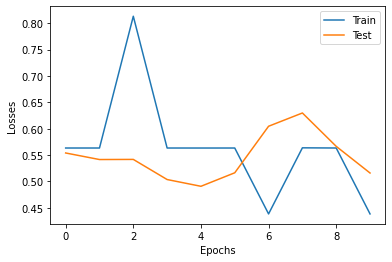

In [ ]:
plt.plot(range(epochs), train_loss, label='Train')
plt.plot(range(epochs), test_loss, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [ ]:
train_loss

array([0.56328535, 0.56328857, 0.81326967, 0.56327957, 0.5632627 ,
       0.56327856, 0.4382619 , 0.56364262, 0.56330222, 0.43826181])

In [ ]:
test_loss

array([0.55386299, 0.54142666, 0.54166311, 0.50348932, 0.49067166,
       0.51630354, 0.60455877, 0.62973344, 0.56643224, 0.51586735])

In [ ]:
cm

tensor([[1.0000, 0.0000],
        [0.2714, 0.0000]])

## Transfer Learning

### VGG16

In [ ]:
model_name = 'vgg16_tl'
from torchvision.models import vgg16, VGG16_Weights
model_conv1 = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)
for param in model_conv1.parameters():
    param.requires_grad = False
print(model_conv1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from prompt_toolkit.shortcuts.dialogs import focus_next
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv1.classifier[6].in_features
features = list(model_conv1.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_ftrs, num_classes)])
# Replace the model classifier
model_conv1.classifier = nn.Sequential(*features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv1 = model_conv1.to(device)
# print(model_conv1)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss() #FocalLoss()
# criteration = nn.NLLLoss() # negative log likelihood loss: useful when you have an unbalanced training set

learning_rate= 0.0001  
reg= 0.001  
epochs = 10
steps= [6, 8]
warmup = 0.001
momentum= 0.9
imbalance='regular'
loss_type= 'CE' #'CE' #'focal'
save_best = True # False
optimizer = torch.optim.SGD(model_conv1.classifier[6].parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

best = 0.0
best_cm = None
best_model = None
# accuracy = np.zeros(epochs)
clas0_accuracy = np.zeros(epochs)
clas1_accuracy = np.zeros(epochs)
clas2_accuracy = np.zeros(epochs)
clas3_accuracy = np.zeros(epochs)
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
for epoch in range(epochs):
  # adjust_learning_rate(optimizer, epoch)

  # train loop
  train_loss[epoch] = train(epoch, train_loader, model_conv1, optimizer, criterion)
  

  # validation loop
  acc, cm, test_loss[epoch] = validate(epoch, test_loader, model_conv1, criterion)
  # accuracy[epoch] = copy.deepcopy(acc)
  cm2 = copy.deepcopy(cm)
  per_cls_acc =  cm2.diag().detach().numpy().tolist()
  clas0_accuracy[epoch] = per_cls_acc[0]
  clas1_accuracy[epoch] = per_cls_acc[1]
  clas2_accuracy[epoch] = per_cls_acc[2]
  clas3_accuracy[epoch] = per_cls_acc[3]
  if acc > best:
    best = acc
    best_cm = cm
    best_model = copy.deepcopy(model_conv1)


print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
per_cls_acc = best_cm.diag().detach().numpy().tolist()
for i, acc_i in enumerate(per_cls_acc):
  print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

if save_best:
  torch.save(best_model.state_dict(), './checkpoints/' + model_name.lower() + '.pth')


Epoch: [0][0/256]	Time 0.103 (0.103)	Loss 1.3658 (1.3658)	Prec @1 0.3125 (0.3125)	
Epoch: [0][100/256]	Time 0.074 (0.076)	Loss 1.2350 (1.2765)	Prec @1 0.3125 (0.4276)	
Epoch: [0][200/256]	Time 0.077 (0.076)	Loss 0.9147 (1.2419)	Prec @1 0.6875 (0.4652)	
Epoch: [0][0/5]	Time 0.558 (0.558)	
Accuracy of Class 0: 0.5530
Accuracy of Class 1: 0.0870
Accuracy of Class 2: 0.8419
Accuracy of Class 3: 0.2323
* Prec @1: 0.5711
Epoch: [1][0/256]	Time 0.080 (0.080)	Loss 0.9514 (0.9514)	Prec @1 0.6875 (0.6875)	
Epoch: [1][100/256]	Time 0.078 (0.077)	Loss 1.1430 (1.1280)	Prec @1 0.4375 (0.5365)	
Epoch: [1][200/256]	Time 0.077 (0.077)	Loss 1.0161 (1.1122)	Prec @1 0.6250 (0.5538)	
Epoch: [1][0/5]	Time 0.545 (0.545)	
Accuracy of Class 0: 0.6136
Accuracy of Class 1: 0.0870
Accuracy of Class 2: 0.8651
Accuracy of Class 3: 0.3131
* Prec @1: 0.6138
Epoch: [2][0/256]	Time 0.075 (0.075)	Loss 0.8293 (0.8293)	Prec @1 0.6250 (0.6250)	
Epoch: [2][100/256]	Time 0.076 (0.077)	Loss 1.0975 (1.0897)	Prec @1 0.6875 (0.5

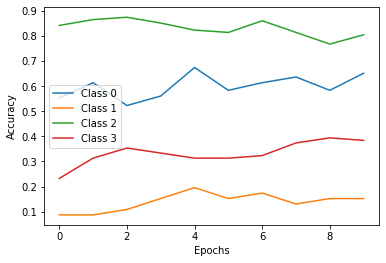

In [ ]:
# plt.plot(range(epochs), train_loss, label='Train')
# plt.plot(range(epochs), test_loss, label='Test')
# plt.xlabel('Epochs')
# plt.ylabel('Losses')
# plt.legend()
# plt.show()

plt.plot(range(epochs), clas0_accuracy, label='Class 0')
plt.plot(range(epochs), clas1_accuracy, label='Class 1')
plt.plot(range(epochs), clas2_accuracy, label='Class 2')
plt.plot(range(epochs), clas3_accuracy, label='Class 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# print("Train Loss:\n", train_loss, "\n Test Loss:\n", test_loss)
print("Class0 Acc:\n", clas0_accuracy, "\n Class1 Acc:\n", clas1_accuracy, "\n Class2 Acc:\n", clas2_accuracy, "\n Class3 Acc:\n", clas3_accuracy)
print("\nConfusion Matrix:\n", best_cm)
print("\nBest Accuuracy:\n", best)

Class0 Acc:
 [0.55303031 0.61363637 0.52272725 0.56060606 0.67424244 0.58333331
 0.61363637 0.63636363 0.58333331 0.65151513] 
 Class1 Acc:
 [0.08695652 0.08695652 0.10869565 0.15217391 0.19565217 0.15217391
 0.17391305 0.13043478 0.15217391 0.15217391] 
 Class2 Acc:
 [0.84186047 0.8651163  0.87441862 0.85116279 0.82325584 0.81395346
 0.86046511 0.81395346 0.76744187 0.80465114] 
 Class3 Acc:
 [0.23232323 0.3131313  0.35353535 0.33333334 0.3131313  0.3131313
 0.32323232 0.37373737 0.39393941 0.38383839]

Confusion Matrix:
 tensor([[0.6742, 0.0652, 0.1256, 0.1313],
        [0.1364, 0.1957, 0.0791, 0.0202],
        [0.2197, 0.1087, 0.8233, 0.0404],
        [0.2652, 0.0870, 0.1349, 0.3131]])

Best Accuuracy:
 tensor(0.6220, device='cuda:0')


In [ ]:
# with nlll
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# criterion = nn.CrossEntropyLoss() #FocalLoss()
criteration = nn.NLLLoss() # negative log likelihood loss: useful when you have an unbalanced training set

learning_rate= 0.0001  
reg= 0.001  
epochs = 10
steps= [6, 8]
warmup = 0.001
momentum= 0.9
imbalance='regular'
loss_type= 'CE' #'CE' #'focal'
save_best = True # False
optimizer = torch.optim.SGD(model_conv1.classifier[6].parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

best = 0.0
best_cm = None
best_model = None
# accuracy = np.zeros(epochs)
clas0_accuracy = np.zeros(epochs)
clas1_accuracy = np.zeros(epochs)
clas2_accuracy = np.zeros(epochs)
clas3_accuracy = np.zeros(epochs)
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
for epoch in range(epochs):
  # adjust_learning_rate(optimizer, epoch)

  # train loop
  train_loss[epoch] = train(epoch, train_loader, model_conv1, optimizer, criterion)
  

  # validation loop
  acc, cm, test_loss[epoch] = validate(epoch, test_loader, model_conv1, criterion)
  # accuracy[epoch] = copy.deepcopy(acc)
  cm2 = copy.deepcopy(cm)
  per_cls_acc =  cm2.diag().detach().numpy().tolist()
  clas0_accuracy[epoch] = per_cls_acc[0]
  clas1_accuracy[epoch] = per_cls_acc[1]
  clas2_accuracy[epoch] = per_cls_acc[2]
  clas3_accuracy[epoch] = per_cls_acc[3]
  if acc > best:
    best = acc
    best_cm = cm
    best_model = copy.deepcopy(model_conv1)


print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
per_cls_acc = best_cm.diag().detach().numpy().tolist()
for i, acc_i in enumerate(per_cls_acc):
  print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

if save_best:
  torch.save(best_model.state_dict(), './checkpoints/' + model_name.lower() + '.pth')


Epoch: [0][0/256]	Time 0.099 (0.099)	Loss 1.5102 (1.5102)	Prec @1 0.1875 (0.1875)	
Epoch: [0][100/256]	Time 0.074 (0.074)	Loss 1.1648 (1.3116)	Prec @1 0.5625 (0.4041)	
Epoch: [0][200/256]	Time 0.075 (0.074)	Loss 1.0710 (1.2522)	Prec @1 0.6875 (0.4580)	
Epoch: [0][0/5]	Time 0.575 (0.575)	
Accuracy of Class 0: 0.6970
Accuracy of Class 1: 0.0435
Accuracy of Class 2: 0.7721
Accuracy of Class 3: 0.1616
* Prec @1: 0.5610
Epoch: [1][0/256]	Time 0.075 (0.075)	Loss 1.3420 (1.3420)	Prec @1 0.4375 (0.4375)	
Epoch: [1][100/256]	Time 0.076 (0.075)	Loss 0.9177 (1.1144)	Prec @1 0.6875 (0.5390)	
Epoch: [1][200/256]	Time 0.076 (0.075)	Loss 1.1064 (1.0996)	Prec @1 0.6250 (0.5597)	
Epoch: [1][0/5]	Time 0.539 (0.539)	
Accuracy of Class 0: 0.6439
Accuracy of Class 1: 0.1304
Accuracy of Class 2: 0.8140
Accuracy of Class 3: 0.2020
* Prec @1: 0.5813
Epoch: [2][0/256]	Time 0.087 (0.087)	Loss 0.9164 (0.9164)	Prec @1 0.6875 (0.6875)	
Epoch: [2][100/256]	Time 0.078 (0.077)	Loss 1.0817 (1.0548)	Prec @1 0.5000 (0.5

In [ ]:
print("Class0 Acc:\n", clas0_accuracy, "\n Class1 Acc:\n", clas1_accuracy, "\n Class2 Acc:\n", clas2_accuracy, "\n Class3 Acc:\n", clas3_accuracy)
print("\nConfusion Matrix:\n", best_cm)
print("\nBest Accuuracy:\n", best)

Class0 Acc:
 [0.69696969 0.64393938 0.58333331 0.62878788 0.62121212 0.54545456
 0.62121212 0.60606062 0.56818181 0.50757575] 
 Class1 Acc:
 [0.04347826 0.13043478 0.15217391 0.10869565 0.08695652 0.17391305
 0.17391305 0.17391305 0.13043478 0.17391305] 
 Class2 Acc:
 [0.772093   0.81395346 0.85116279 0.82325584 0.79534882 0.86046511
 0.8465116  0.85116279 0.85116279 0.85116279] 
 Class3 Acc:
 [0.16161616 0.2020202  0.37373737 0.35353535 0.28282827 0.36363637
 0.4040404  0.24242425 0.44444445 0.37373737]

Confusion Matrix:
 tensor([[0.6212, 0.0435, 0.1116, 0.2424],
        [0.1212, 0.1739, 0.0791, 0.0505],
        [0.1439, 0.0000, 0.8465, 0.1414],
        [0.1742, 0.0652, 0.1535, 0.4040]])

Best Accuuracy:
 tensor(0.6341, device='cuda:0')


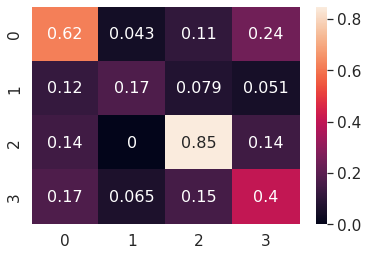

In [ ]:
import seaborn as sn
import pandas as pd
# import matplotlib.pyplot as plt
array = np.array(best_cm)
cm_ = pd.DataFrame(array, range(num_classes), range(num_classes))
sn.set(font_scale=1.4) #label size
sn.heatmap(cm_, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### Vgg-16 with conv parameters to be optimized

### VGG16 with Batch Normalization

In [ ]:
model_name = 'vgg16_bn_tl'
from torchvision.models import vgg16_bn, VGG16_BN_Weights   
model_conv2 = torchvision.models.vgg16_bn(VGG16_BN_Weights.DEFAULT)
for param in model_conv2.parameters():
    param.requires_grad = False

In [ ]:
print(model_conv2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
from prompt_toolkit.shortcuts.dialogs import focus_next
from prompt_toolkit.shortcuts.dialogs import focus_next
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv2.classifier[6].in_features
features = list(model_conv2.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_ftrs, num_classes)])
# Replace the model classifier
model_conv2.classifier = nn.Sequential(*features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv2 = model_conv2.to(device)

criterion = nn.CrossEntropyLoss() #FocalLoss()
# criteration = nn.NLLLoss() # negative log likelihood loss: useful when you have an unbalanced training set
optimizer = torch.optim.SGD(model_conv2.classifier[6].parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

# print(model_conv2)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# criterion = nn.CrossEntropyLoss() #FocalLoss()
criteration = nn.NLLLoss() # negative log likelihood loss: useful when you have an unbalanced training set

learning_rate= 0.0001  
reg= 0.001  
epochs = 30
steps= [6, 8]
warmup = 0.001
momentum= 0.9
imbalance='regular'
loss_type= 'NLLL' #'CE' #'focal'
save_best = True # False
optimizer = torch.optim.SGD(model_conv2.classifier[6].parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

best = 0.0
best_cm = None
best_model = None
# accuracy = np.zeros(epochs)
clas0_accuracy = np.zeros(epochs)
clas1_accuracy = np.zeros(epochs)
clas2_accuracy = np.zeros(epochs)
clas3_accuracy = np.zeros(epochs)
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
for epoch in range(epochs):
  # adjust_learning_rate(optimizer, epoch)

  # train loop
  train_loss[epoch] = train(epoch, train_loader, model_conv2, optimizer, criterion)
  

  # validation loop
  acc, cm, test_loss[epoch] = validate(epoch, test_loader, model_conv2, criterion)
  # accuracy[epoch] = copy.deepcopy(acc)
  cm2 = copy.deepcopy(cm)
  per_cls_acc =  cm2.diag().detach().numpy().tolist()
  clas0_accuracy[epoch] = per_cls_acc[0]
  clas1_accuracy[epoch] = per_cls_acc[1]
  clas2_accuracy[epoch] = per_cls_acc[2]
  clas3_accuracy[epoch] = per_cls_acc[3]
  if acc > best:
    best = acc
    best_cm = cm
    best_model = copy.deepcopy(model_conv2)


print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
per_cls_acc = best_cm.diag().detach().numpy().tolist()
for i, acc_i in enumerate(per_cls_acc):
  print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

if save_best:
  torch.save(best_model.state_dict(), './checkpoints/' + model_name.lower() + '.pth')


Epoch: [0][0/256]	Time 0.116 (0.116)	Loss 1.4929 (1.4929)	Prec @1 0.1875 (0.1875)	
Epoch: [0][100/256]	Time 0.088 (0.088)	Loss 1.1317 (1.2991)	Prec @1 0.5000 (0.4152)	
Epoch: [0][200/256]	Time 0.090 (0.088)	Loss 1.2788 (1.2511)	Prec @1 0.3750 (0.4596)	
Epoch: [0][0/5]	Time 0.640 (0.640)	
Accuracy of Class 0: 0.5303
Accuracy of Class 1: 0.0000
Accuracy of Class 2: 0.8698
Accuracy of Class 3: 0.2828
* Prec @1: 0.5793
Epoch: [1][0/256]	Time 0.094 (0.094)	Loss 1.0600 (1.0600)	Prec @1 0.6875 (0.6875)	
Epoch: [1][100/256]	Time 0.089 (0.089)	Loss 0.8930 (1.1437)	Prec @1 0.7500 (0.5538)	
Epoch: [1][200/256]	Time 0.088 (0.089)	Loss 1.3079 (1.1393)	Prec @1 0.3125 (0.5410)	
Epoch: [1][0/5]	Time 0.614 (0.614)	
Accuracy of Class 0: 0.5758
Accuracy of Class 1: 0.0217
Accuracy of Class 2: 0.8372
Accuracy of Class 3: 0.2727
* Prec @1: 0.5772
Epoch: [2][0/256]	Time 0.095 (0.095)	Loss 0.7119 (0.7119)	Prec @1 0.7500 (0.7500)	
Epoch: [2][100/256]	Time 0.087 (0.088)	Loss 0.8165 (1.0772)	Prec @1 0.7500 (0.5

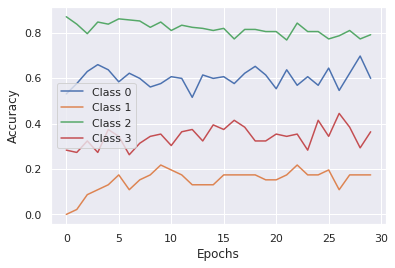

In [ ]:
import matplotlib.pyplot as plt
sn.set(font_scale=1.0)
plt.plot(range(epochs), clas0_accuracy, label='Class 0')
plt.plot(range(epochs), clas1_accuracy, label='Class 1')
plt.plot(range(epochs), clas2_accuracy, label='Class 2')
plt.plot(range(epochs), clas3_accuracy, label='Class 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Class0 Acc:\n", clas0_accuracy, "\n Class1 Acc:\n", clas1_accuracy, "\n Class2 Acc:\n", clas2_accuracy, "\n Class3 Acc:\n", clas3_accuracy)
print("\nConfusion Matrix:\n", best_cm)
print("\nBest Accuuracy:\n", best)

Class0 Acc:
 [0.530303   0.57575756 0.62878788 0.65909094 0.63636363 0.58333331
 0.62121212 0.59848487 0.56060606 0.57575756 0.60606062 0.59848487
 0.5151515  0.61363637 0.59848487 0.60606062 0.57575756 0.62121212
 0.65151513 0.61363637 0.55303031 0.63636363 0.56818181 0.60606062
 0.56818181 0.64393938 0.54545456 0.62121212 0.69696969 0.59848487] 
 Class1 Acc:
 [0.         0.02173913 0.08695652 0.10869565 0.13043478 0.17391305
 0.10869565 0.15217391 0.17391305 0.2173913  0.19565217 0.17391305
 0.13043478 0.13043478 0.13043478 0.17391305 0.17391305 0.17391305
 0.17391305 0.15217391 0.15217391 0.17391305 0.2173913  0.17391305
 0.17391305 0.19565217 0.10869565 0.17391305 0.17391305 0.17391305] 
 Class2 Acc:
 [0.86976743 0.83720928 0.79534882 0.8465116  0.83720928 0.86046511
 0.85581398 0.85116279 0.82325584 0.8465116  0.80930233 0.83255816
 0.82325584 0.81860465 0.80930233 0.81860465 0.772093   0.81395346
 0.81395346 0.80465114 0.80465114 0.76744187 0.84186047 0.80465114
 0.80465114 0.772

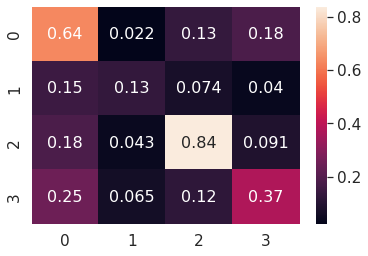

In [ ]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
array = np.array(best_cm)
cm_ = pd.DataFrame(array, range(num_classes), range(num_classes))
sn.set(font_scale=1.4) #label size
sn.heatmap(cm_, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### ResNet50

In [ ]:
model_name = 'Resnet50-tl'
from torchvision.models import resnet50, ResNet50_Weights
# model_conv = torchvision.models.resnet18(pretrained=True)

# # Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
model_conv = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
# also check
#vgg_based = torchvision.models.vgg19(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


In [ ]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# from prompt_toolkit.shortcuts.dialogs import focus_next
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_conv.conv3 = nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
model_conv.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss() #FocalLoss()
criteration = nn.NLLLoss() # negative log likelihood loss: useful when you have an unbalanced training set

# Observe that only parameters of final layer are being optimized as opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

# Decay LR by a factor of 0.1 every 10 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
criteration = nn.NLLLoss()
learning_rate= 0.0001  
reg= 0.001  
epochs= 30
steps= [6, 8]
warmup = 0.001
momentum= 0.9
model_name = 'ResNet50-tl' #'MyModel'  # 'ResNet-32'
imbalance='regular'
loss_type= 'CE' #'CE' #'focal'
save_best = True # False

optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=reg)

In [ ]:
# 1) loss = nlll
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

best = 0.0
best_cm = None
best_model = None
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)
clas0_accuracy = np.zeros(epochs)
clas1_accuracy = np.zeros(epochs)
clas2_accuracy = np.zeros(epochs)
clas3_accuracy = np.zeros(epochs)
for epoch in range(epochs):
  # adjust_learning_rate(optimizer, epoch)

  # train loop
  train_loss[epoch] = train(epoch, train_loader, model_conv, optimizer, criterion)
  

  # validation loop
  acc, cm, test_loss[epoch] = validate(epoch, test_loader, model_conv, criterion)
  cm2 = copy.deepcopy(cm)
  per_cls_acc =  cm2.diag().detach().numpy().tolist()
  clas0_accuracy[epoch] = per_cls_acc[0]
  clas1_accuracy[epoch] = per_cls_acc[1]
  clas2_accuracy[epoch] = per_cls_acc[2]
  clas3_accuracy[epoch] = per_cls_acc[3]
  if acc > best:
    best = acc
    best_cm = cm
    best_model = copy.deepcopy(model_conv)

print('Best Prec @1 Acccuracy: {:.4f}'.format(best))
per_cls_acc = best_cm.diag().detach().numpy().tolist()
for i, acc_i in enumerate(per_cls_acc):
  print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

if save_best:
  torch.save(best_model.state_dict(), './checkpoints/' + model_name.lower() + '.pth')


Epoch: [0][0/256]	Time 0.085 (0.085)	Loss 1.3948 (1.3948)	Prec @1 0.3125 (0.3125)	
Epoch: [0][100/256]	Time 0.051 (0.051)	Loss 1.2618 (1.3615)	Prec @1 0.3750 (0.3137)	
Epoch: [0][200/256]	Time 0.050 (0.051)	Loss 1.2439 (1.3428)	Prec @1 0.4375 (0.3386)	
Epoch: [0][0/5]	Time 0.345 (0.345)	
Accuracy of Class 0: 0.2879
Accuracy of Class 1: 0.0000
Accuracy of Class 2: 0.9302
Accuracy of Class 3: 0.0101
* Prec @1: 0.4858
Epoch: [1][0/256]	Time 0.054 (0.054)	Loss 1.2770 (1.2770)	Prec @1 0.3125 (0.3125)	
Epoch: [1][100/256]	Time 0.050 (0.051)	Loss 1.2690 (1.2942)	Prec @1 0.3125 (0.4381)	
Epoch: [1][200/256]	Time 0.051 (0.051)	Loss 1.3359 (1.2736)	Prec @1 0.1250 (0.4574)	
Epoch: [1][0/5]	Time 0.346 (0.346)	
Accuracy of Class 0: 0.3939
Accuracy of Class 1: 0.0000
Accuracy of Class 2: 0.9628
Accuracy of Class 3: 0.0202
* Prec @1: 0.5305
Epoch: [2][0/256]	Time 0.049 (0.049)	Loss 1.3369 (1.3369)	Prec @1 0.3125 (0.3125)	
Epoch: [2][100/256]	Time 0.050 (0.052)	Loss 1.1298 (1.2349)	Prec @1 0.6250 (0.4

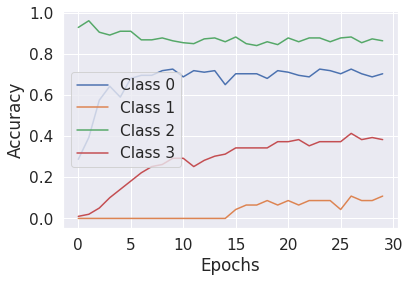

In [ ]:
plt.plot(range(epochs), clas0_accuracy, label='Class 0')
plt.plot(range(epochs), clas1_accuracy, label='Class 1')
plt.plot(range(epochs), clas2_accuracy, label='Class 2')
plt.plot(range(epochs), clas3_accuracy, label='Class 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Class0 Acc:\n", clas0_accuracy, "\n Class1 Acc:\n", clas1_accuracy, "\n Class2 Acc:\n", clas2_accuracy, "\n Class3 Acc:\n", clas3_accuracy)
print("\nConfusion Matrix:\n", best_cm)
print("\nBest Accuuracy:\n", best)

Class0 Acc:
 [0.28787878 0.39393941 0.57575756 0.64393938 0.59090906 0.68181819
 0.69696969 0.69696969 0.719697   0.72727275 0.68939394 0.719697
 0.71212119 0.719697   0.65151513 0.70454544 0.70454544 0.70454544
 0.68181819 0.719697   0.71212119 0.69696969 0.68939394 0.72727275
 0.719697   0.70454544 0.72727275 0.70454544 0.68939394 0.70454544] 
 Class1 Acc:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04347826 0.06521739 0.06521739
 0.08695652 0.06521739 0.08695652 0.06521739 0.08695652 0.08695652
 0.08695652 0.04347826 0.10869565 0.08695652 0.08695652 0.10869565] 
 Class2 Acc:
 [0.93023258 0.96279067 0.90697676 0.89302325 0.91162789 0.91162789
 0.86976743 0.86976743 0.87906975 0.8651163  0.85581398 0.85116279
 0.87441862 0.87906975 0.86046511 0.88372093 0.85116279 0.84186047
 0.86046511 0.8465116  0.87906975 0.86046511 0.87906975 0.87906975
 0.86046511 0.87906975 0.88372093 0

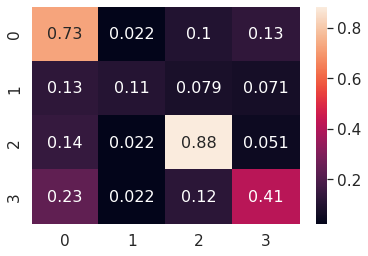

In [ ]:
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
array = np.array(best_cm)
cm_ = pd.DataFrame(array, range(num_classes), range(num_classes))
sn.set(font_scale=1.4) #label size
sn.heatmap(cm_, annot=True, annot_kws={"size": 16}) # font size
plt.show()